In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("saved/5m_conf_cs_preprocessed_text.csv", index_col=0)

In [2]:
df.columns.tolist()

['PaperId',
 'Abstract',
 'Author_1',
 'Author_10',
 'Author_11',
 'Author_2',
 'Author_3',
 'Author_4',
 'Author_5',
 'Author_6',
 'Author_7',
 'Author_8',
 'Author_9',
 'CitationCount',
 'CitationCountPerYear',
 'FieldOfStudy_0',
 'FieldOfStudy_1',
 'FieldOfStudy_2',
 'FieldOfStudy_3',
 'FieldOfStudy_4',
 'FieldOfStudy_5',
 'FirstPage',
 'JournalName',
 'LastPage',
 'PaperId.1',
 'PublishedDate',
 'Publisher',
 'Rank',
 'Title',
 'YearsSincePublication',
 'AuthorProminence',
 'MagBin',
 'CitationBin',
 'AuthorRank',
 'JournalNameRank',
 'PublisherRank',
 'processed_abstract']

In [3]:
cc = df["CitationCount"].values

In [4]:
def custom_binning(x, set=None):
    thresholds = [4, 10, 100, 1000]
    if set:
        thresholds = set.copy()
        thresholds.sort()
    if x <= thresholds[0]: 
        return 1
    elif x <= thresholds[1]:
        return 2
    elif x <= thresholds[2]:
        return 3
    else:
        return 4

In [5]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4, random_state=0)
gmm.fit(cc.reshape(-1,1))
gmm.means_

array([[ 10.85290406],
       [829.92259047],
       [  1.34139704],
       [ 93.43209027]])

In [6]:
df["citation_bin"] = pd.Series(gmm.predict(cc.reshape(-1, 1)), name="citation_bin")

In [7]:
np.unique(df.citation_bin, return_counts=True)

(array([0, 1, 2, 3]), array([ 92579,   3251, 159694,  26932]))

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation(df, columns=None, plot=True):
    t = df[columns] if columns else df
    if not plot:
        print(t.corr())
    else:
        fig = plt.figure()
        mask = np.triu(t.corr())
        sns.heatmap(
            t.corr(),
            mask=mask,
            cbar=False,
            square=True,
            annot=True,
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm_r",
            linecolor="black",
        )
        plt.show()

In [9]:
df.columns

Index(['PaperId', 'Abstract', 'Author_1', 'Author_10', 'Author_11', 'Author_2',
       'Author_3', 'Author_4', 'Author_5', 'Author_6', 'Author_7', 'Author_8',
       'Author_9', 'CitationCount', 'CitationCountPerYear', 'FieldOfStudy_0',
       'FieldOfStudy_1', 'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4',
       'FieldOfStudy_5', 'FirstPage', 'JournalName', 'LastPage', 'PaperId.1',
       'PublishedDate', 'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank', 'processed_abstract',
       'citation_bin'],
      dtype='object')

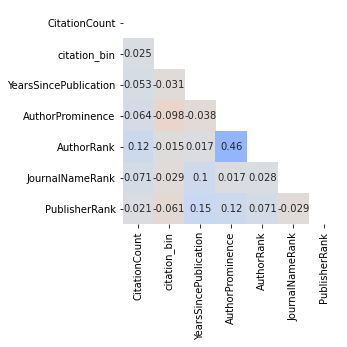

In [10]:
correlation(df, columns=[
    "CitationCount",
    "citation_bin",
    "YearsSincePublication",
    "AuthorProminence",
    "AuthorRank",
    "JournalNameRank",
    "PublisherRank"
])

In [152]:
dfs = []
min_size = np.inf
for i in np.unique(df.citation_bin):
    dfs.append(df[df.citation_bin == i])
    min_size = dfs[-1].shape[0] if dfs[-1].shape[0] < min_size else min_size
dfs = [d.sample(frac=1).iloc[:min_size] for d in dfs]
df_c = pd.concat(dfs)
df_c = df_c.sample(frac=1).reset_index(drop=True)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_c[
        [
            "YearsSincePublication",
            "AuthorProminence",
            "AuthorRank",
            "JournalNameRank", 
            "PublisherRank"
        ]
    ],
    df_c.citation_bin)

In [14]:
from sklearn.metrics import classification_report
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [15]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.35      0.29      0.32       831
           1       0.53      0.58      0.55       835
           2       0.52      0.60      0.56       772
           3       0.35      0.33      0.34       813

    accuracy                           0.45      3251
   macro avg       0.44      0.45      0.44      3251
weighted avg       0.44      0.45      0.44      3251



In [16]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.37      0.32      0.35       831
           1       0.54      0.58      0.56       835
           2       0.56      0.62      0.59       772
           3       0.36      0.34      0.35       813

    accuracy                           0.47      3251
   macro avg       0.46      0.47      0.46      3251
weighted avg       0.46      0.47      0.46      3251



In [153]:
cs_corpus = open("data_tools/cs_lexicon.txt", "r").read()
cs_corpus = set(cs_corpus.split("\n"))

In [154]:
def filter_cs(string):
    tokens = string.split(" ")
    tokens = filter(lambda x: x in cs_corpus, tokens)
    return " ".join(list(tokens))

In [156]:
df_c["cs_corpus_text"] = pd.Series([filter_cs(x) for x in df_c.processed_abstract])

In [157]:
df_c.cs_corpus_text

0        laboratory electronic algorithm vector archite...
1        feasible algorithm process workload linear heu...
2                     application profile genetic retrieve
3        dependency tag token syntax dataset dependency...
4                 concurrency semantic process application
                               ...                        
12999    enterprise defect null profile metric dependen...
13000    histogram video database histogram encode spat...
13001                                      genetic genetic
13002    internet mobile network mobile mobile cache mo...
13003    bit embed robust pixel pixel pixel pixel pixel...
Name: cs_corpus_text, Length: 13004, dtype: object

In [158]:
def vectorize_text(df, text_col, vectorizer):
    vectorized = vectorizer.fit_transform(df[text_col])
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(
        vectorized, columns=vectorizer.get_feature_names(), index=df.index
    )

    return vectorized_df, vectorizer

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
df_bow, vectorizer = vectorize_text(
        df_c, "cs_corpus_text", CountVectorizer(min_df=0.07)
    )

In [160]:
df_bow

,algorithm,application,architecture,network,novel,process,software
0,2,2,1,0,0,0,1
1,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0
3,0,0,3,0,0,0,0
4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...
12999,0,0,0,0,0,0,0
13000,2,0,0,0,1,0,0
13001,0,0,0,0,0,0,0
13002,0,0,0,1,0,0,0


In [161]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_bow)

In [162]:
df_c["bin"] = [0 if x < 2 else 1 for x in df_c.citation_bin]

In [163]:
df_c.bin

0        0
1        0
2        1
3        0
4        0
        ..
12999    0
13000    0
13001    0
13002    0
13003    1
Name: bin, Length: 13004, dtype: int64

Text(0.5, 1.0, 'UMAP projection Bag-of-Words')

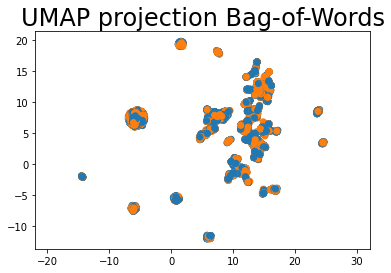

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_c.bin]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection Bag-of-Words', fontsize=24)

In [165]:
df_text = pd.merge(df_c[
        [
            "YearsSincePublication",
            "AuthorProminence",
            "AuthorRank",
            "JournalNameRank", 
            "PublisherRank"
        ]
    ], df_bow, left_index=True, right_index=True)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text,
    df_c.bin)

In [167]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.58      1634
           1       0.57      0.54      0.55      1617

    accuracy                           0.57      3251
   macro avg       0.57      0.57      0.57      3251
weighted avg       0.57      0.57      0.57      3251

